# PixelCNN

This is an attempt to re-implement the paper pixelCNN

Paper: https://arxiv.org/pdf/1606.05328.pdf

Other Resources: 
* https://keras.io/examples/generative/pixelcnn/

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
(ds_train, ds_test), ds_info = tfds.load('mnist', 
                              split=['test', 'test'], 
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)

#fig = tfds.show_examples(ds_info, ds_train)

def binarize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, tf.cast(image, tf.int32)

ds_train = ds_train.map(binarize)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_test = ds_test.map(binarize).batch(64).cache().prefetch(64)

img_shape = next(iter(ds_train))[0].shape[1:]

In [34]:
class MaskedConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides = (1, 1), padding = 'SAME', mask_type = None, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding.upper()
        self.mask_type = mask_type
        
    def build(self, input_shape):
        init = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 1.0)
        self.kernel = self.add_weight(shape = self.kernel_size + (input_shape[-1], self.filters), initializer = init, 
                                      trainable = True, name = 'MaskedConv2D_kernel')
        self.bias = self.add_weight(shape = (1, self.filters), initializer = 'zeros', 
                                    trainable = True, name = 'MaskedConv2D_bias')
        
        mask = np.ones(self.kernel_size[0]*self.kernel_size[1], dtype = np.float32)
        center = len(mask)//2
        mask[center + 1:] = 0
        
        if self.mask_type == 'A':
            mask[center] = 0
            
        mask = mask.reshape((self.kernel_size[0], self.kernel_size[1], 1, 1))
        self.mask = tf.constant(mask, dtype = tf.float32)
        
    def call(self, inputs):
        masked_kernel = tf.multiply(self.kernel, self.mask)
        out = tf.add(tf.nn.conv2d(inputs, masked_kernel, self.strides, self.padding), self.bias)
        return out

In [35]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.relu1 = tf.keras.layers.ReLU()
        
        self.masked_conv = MaskedConv2D(filters = filters//2, kernel_size = (3, 3), strides = (1, 1), mask_type = 'B')
        self.relu0 = tf.keras.layers.ReLU()
        
        self.conv2 = tf.keras.layers.Conv2D(filters = filters, kernel_size = (1, 1), strides = (1, 1), padding = 'same')
        self.relu2 = tf.keras.layers.ReLU()
        
    def call(self, inputs):
        x = self.relu1(self.conv1(inputs))
        x = self.relu0(self.masked_conv(x))
        x = self.relu2(self.conv2(x))
        return tf.add(x, inputs)

In [36]:
def build_model(num_res_block = 5):
    inp = tf.keras.layers.Input(shape = (img_shape), dtype = tf.float32, name = 'pixel_cnn_input')
    
    x = MaskedConv2D(filters = 128, kernel_size = (7, 7), mask_type = 'A')(inp)
    x = tf.keras.layers.ReLU()(x)
    
    for _ in range(num_res_block):
        x = ResidualBlock(filters = 128)(x)
    
    for _ in range(2):
        x = MaskedConv2D(filters = 128, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', mask_type = 'B')(x)
        x = tf.keras.layers.ReLU()(x)
        
    x = tf.keras.layers.Conv2D(filters = 1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    
    return tf.keras.models.Model(inp, x, name = 'PixelCNN')

In [47]:
model = build_model()
model.summary()

In [40]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0005), 
              loss = tf.keras.losses.BinaryCrossentropy())

In [42]:
model.fit(ds_train, epochs = 50, validation_data=ds_test)

Epoch 1/50
157/157 [==============================] - 15s 71ms/step - loss: 14758.6084 - val_loss: 2179.1125
Epoch 2/50
157/157 [==============================] - 11s 69ms/step - loss: 1426.9584 - val_loss: 935.2094
Epoch 3/50
157/157 [==============================] - 11s 70ms/step - loss: 936.9624 - val_loss: 576.8968
Epoch 4/50
157/157 [==============================] - 11s 70ms/step - loss: 483.0316 - val_loss: 432.0533
Epoch 5/50
157/157 [==============================] - 11s 70ms/step - loss: 372.8530 - val_loss: 336.7756
Epoch 6/50
157/157 [==============================] - 11s 70ms/step - loss: 395.7571 - val_loss: 228.5179
Epoch 7/50
157/157 [==============================] - 11s 71ms/step - loss: 219.4834 - val_loss: 187.0056
Epoch 8/50
157/157 [==============================] - 11s 71ms/step - loss: 193.9772 - val_loss: 156.4915
Epoch 9/50
157/157 [==============================] - 11s 71ms/step - loss: 161.9327 - val_loss: 127.3643
Epoch 10/50
157/157 [=====================

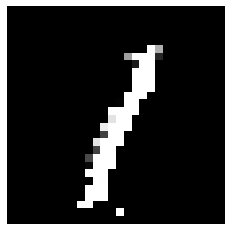

In [92]:
plt.imshow(model(next(iter(ds_train))[0])[0], cmap = 'binary_r')
plt.axis('off')
plt.show()